___
# **Parameter Estimation for Ion Exchange**
___


This demonstration will present the steps for setting up and conducting a parameter estimation for the WaterTAP ion exchange (IX) model. This tutorial will go through the steps to fit the IX model to breakthrough data for PFAS species. 

## Model Equations

The [WaterTAP IX model](https://watertap.readthedocs.io/en/stable/technical_reference/unit_models/ion_exchange_0D.html) we will be using is an implementation of the Clark model. This model includes three parameters related to the bed capacity, equilibrium, and mass transfer of the solute of interest on to the media. The governing equation is shown below.

$$
\frac{\textcolor{red}{C_b}}{\textcolor{red}{C_0}} =
\frac{1}{\left( 1 +
\left(2^{\textcolor{RoyalBlue}{n} - 1} - 1\right)
\exp\left[
\frac{\textcolor{RoyalBlue}{k_T} Z (\textcolor{RoyalBlue}{n} - 1)}
{\textcolor{RoyalBlue}{BV_{50}} \, u_{bed}}
\left(\textcolor{RoyalBlue}{BV_{50}} - \textcolor{green}{BV}\right)
\right]
\right)^{\tfrac{1}{\textcolor{RoyalBlue}{n} - 1}}}
$$

<!-- **Color Legend:**   -->
- $u_{bed}$ = bed loading rate, adopted from pilot experiments
- $Z$ = bed depth, adopted from pilot experiments
- $\textcolor{red}{C_b/C_0}$ = Effluent concentration ratio, determined from pilot experiments
- $\textcolor{green}{BV}$ = Bed volumes treated, determined from pilot experiments
- $\textcolor{RoyalBlue}{BV_{50}}$, $\textcolor{RoyalBlue}{k_{T}}$, and $\textcolor{RoyalBlue}{n}$ = Clark model parameters to be fit with parameter estimation

For our parameter estimation, we want to estimate the values for $\textcolor{RoyalBlue}{BV_{50}}$, $\textcolor{RoyalBlue}{k_{T}}$, and $\textcolor{RoyalBlue}{n}$ to know the $\textcolor{green}{BV}$ that the relative effluent concentration approximates $\textcolor{red}{ C_b/C_0}$. 


___
## **Part 1 - Solve Parameter Estimation with Breakthrough Data**
### **1.1 Import required modules**
Import all Pyomo, WaterTAP and helper modules needed for building and solving the parameter estimation problem.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

from pyomo.environ import (
    ConcreteModel,
    value,
    assert_optimal_termination,
    units as pyunits,
)
import pyomo.contrib.parmest.parmest as parmest

from idaes.core import FlowsheetBlock
import idaes.core.util.scaling as iscale
from idaes.core.util.model_statistics import degrees_of_freedom

from watertap.core.solvers import get_solver
from watertap.property_models.multicomp_aq_sol_prop_pack import MCASParameterBlock
from watertap.unit_models.ion_exchange_0D import IonExchange0D

solver = get_solver()

### **1.2 Gather and prepare the data**
*How does data need to be formatted for parmest?*


- **Pandas Dataframe:** each column is an observed quantity and each row represents a scenario.

**Other options:**
- **List of dictionaries:** each entry of the list is a distinct scenario, each key an observed quantity 
- **List of json file names:** each entry of the list contains a json file with the distinct scenario (for large datasets in parallel computing)

In this tutorial, we use the data collected from a pilot plant from [Orange County Water District (OCWD)](https://www.ocwd.com) for treating PFAS with IX.

,bv,cb,species,resin,c0,c_norm,curve_id,mw,molar_vol
0,15131.51332,0.044226,PFOA,a694e,15.8,0.002799,1,0.41407,0.000272
1,56630.53237,0.060187,PFOA,a694e,15.8,0.003809,1,0.41407,0.000272
2,69166.69438,0.065008,PFOA,a694e,15.8,0.004114,1,0.41407,0.000272
3,77002.62694,1.971868,PFOA,a694e,15.8,0.124802,1,0.41407,0.000272
4,85257.53999,3.417351,PFOA,a694e,15.8,0.216288,1,0.41407,0.000272
5,103017.65700,4.693413,PFOA,a694e,15.8,0.297051,1,0.41407,0.000272
6,109548.43210,6.311309,PFOA,a694e,15.8,0.399450,1,0.41407,0.000272
7,135124.53030,8.801915,PFOA,a694e,15.8,0.557083,1,0.41407,0.000272
8,152490.60620,11.404748,PFOA,a694e,15.8,0.721820,1,0.41407,0.000272
9,178060.05390,13.664583,PFOA,a694e,15.8,0.864847,1,0.41407,0.000272


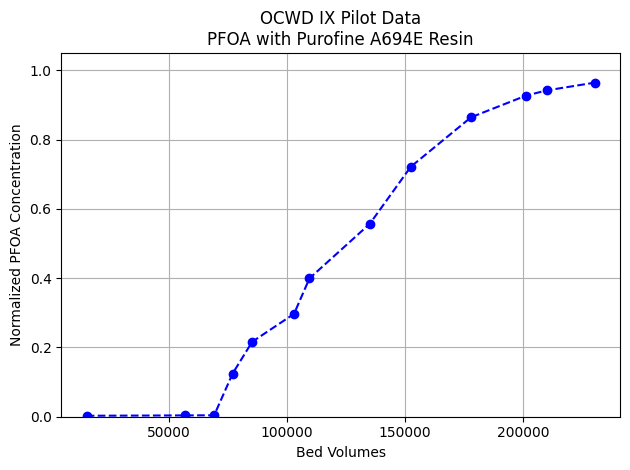

In [2]:
# Read in all data
all_data = pd.read_csv("breakthrough_data.csv")

# Use data from first curve only
data = all_data[all_data.curve_id == 1].copy()
species = data.iloc[0]["species"]
fig, ax = plt.subplots()
ax.plot(data["bv"], data["c_norm"], marker="o", color="blue", ls="--")
ax.set_xlabel("Bed Volumes")
ax.set_ylabel(f"Normalized {species} Concentration")
ax.set_title(f"OCWD IX Pilot Data\n{species} with Purofine A694E Resin")
ax.grid(visible=True)
ax.set_ylim(0, 1.05)
fig.tight_layout()

data

### **1.3 Define the IX model for parameter estimation**
*What model are parameters being fit to?*

***Parmest*** requires a "model function" that takes in the data and returns a Pyomo model.

Set up the WaterTAP model defining:
- Vars for each parameter (or `theta`) to be estimated
- the model equation (a function of the observed data; in this case, breakthrough time as a function of outlet concentration)

The IX model we are using is defined by the flowsheet returned from the `ix_parmest` function. Importantly, the flowsheet returned must be set to the conditions for the scenario in `data`.

In [ ]:
def ix_parmest(data):
    """
    Build for OCWD IX Pilot System
    """

    # Pilot system parameters
    bed_depth = 29 * pyunits.inch
    bed_vol = 95.44 * pyunits.inches**3
    col_diam = 2.05 * pyunits.inch
    flow_rate = 0.2 * pyunits.gallon / pyunits.minute
    ebct = 2.07 * pyunits.minute
    # Using Purofine PFA694 resin properties
    resin_dens = 720 * pyunits.kg / pyunits.m**3
    resin_diam = 0.000675 * pyunits.m

    # Inlet conditions
    species = data.iloc[0]["species"]
    c0 = data.iloc[0]["c0"] * pyunits.ng / pyunits.L
    mw = data.iloc[0]["mw"] * pyunits.kg / pyunits.mol
    molar_vol = data.iloc[0]["molar_vol"] * pyunits.m**3 / pyunits.mol

    ion_props = {
        "solute_list": [species],
        "mw_data": {"H2O": 0.018, species: mw},
        "molar_volume_data": {("Liq", species): molar_vol},
        "diffus_calculation": "HaydukLaudie",
        "charge": {species: -1},
    }

    # Build model
    m = ConcreteModel()
    m.fs = FlowsheetBlock(dynamic=False)
    m.fs.properties = MCASParameterBlock(**ion_props)

    # Add IX model
    ix_config = {
        "property_package": m.fs.properties,
        "target_ion": species,
        # Use Freundlich isotherm for Clark model
        "isotherm": "freundlich",
        "regenerant": "single_use",
    }
    m.fs.ix = ix = IonExchange0D(**ix_config)

    # Set feed conditions
    pfas_mol_flow = pyunits.convert(
        c0 / mw * flow_rate, to_units=pyunits.mol / pyunits.s
    )
    h2o_mol_flow = 55.5 * pyunits.mol / pyunits.liter * flow_rate
    ix.process_flow.properties_in[0].flow_mol_phase_comp["Liq", "H2O"].fix(h2o_mol_flow)
    ix.process_flow.properties_in[0].flow_mol_phase_comp["Liq", species].fix(
        pfas_mol_flow
    )
    ix.process_flow.properties_in[0].pressure.fix(101325)
    ix.process_flow.properties_in[0].temperature.fix(298)

    # Adjust bounds for pilot system and parameter estimation
    ix.bed_depth.setlb(0)
    ix.bed_vol_tot.setub(bed_vol)
    ix.col_diam.setlb(0)
    ix.ebct.setlb(0)
    ix.vel_bed.setlb(0)
    ix.vel_bed.setub(1)
    ix.freundlich_n.setlb(1.05)
    ix.freundlich_n.setub(100)
    ix.col_height_to_diam_ratio.setlb(0)

    # Fix known parameters
    ix.col_diam.set_value(col_diam)
    ix.resin_bulk_dens.fix(resin_dens)
    ix.resin_diam.fix(resin_diam)
    ix.bed_depth.fix(bed_depth)
    ix.ebct.fix(ebct)
    ix.number_columns.fix(1)
    ix.c_norm.fix(0.5)

    # Deactivate steady-state constraints
    # We don't need these for parameter estimation
    ix.eq_c_traps.deactivate()
    ix.c_traps.fix()
    ix.eq_tb_traps.deactivate()
    ix.tb_traps.fix()
    ix.eq_traps.deactivate()
    ix.traps.fix()
    ix.eq_c_norm_avg.deactivate()
    ix.c_norm_avg.fix(1e-3)
    ix.process_flow.mass_transfer_term.fix(0)

    # Initial guess for parameters to be estimated
    ix.bv_50.fix(120000)
    ix.mass_transfer_coeff.fix(0.2)
    ix.freundlich_n.fix(2.0)

    # Scale model
    m.fs.properties.set_default_scaling(
        "flow_mol_phase_comp", 1 / value(h2o_mol_flow), index=("Liq", "H2O")
    )
    m.fs.properties.set_default_scaling(
        "flow_mol_phase_comp",
        1 / value(pfas_mol_flow),
        index=("Liq", species),
    )

    iscale.set_scaling_factor(ix.bed_vol_tot, 1e4)
    iscale.calculate_scaling_factors(m)

    # Solve at initial point
    assert degrees_of_freedom(m) == 0
    m.fs.ix.initialize()
    results = solver.solve(m)
    assert_optimal_termination(results)

    # Set conditions from data
    ix.c_norm.fix(data.iloc[0]["c_norm"])
    ix.bv.set_value(data.iloc[0]["bv"])
    assert degrees_of_freedom(m) == 0
    # Re-solve
    m.fs.ix.initialize()
    results = solver.solve(m)
    assert_optimal_termination(results)

    clear_output(wait=False)
    print(f"Running model with C/C0 = {value(ix.c_norm[species]):.4f}")

    return m


m = ix_parmest(data)

### **1.4 Define a list of parameter names**

The variables to be estimated by parmest must be given as a list of strings of the variable names as they are defined in `ix_parmest`.

Note: these can be determined by accessing the `name` attribute on any Pyomo/WaterTAP component, for example:

```
m.fs.ix.bv_50.name
```

In [ ]:
# Variables from model to be estimated
# Required format: list with strings of variables names as they could be found on the model
theta_names = ["fs.ix.bv_50", "fs.ix.mass_transfer_coeff", "fs.ix.freundlich_n"]

### **1.5 Define an objective function**

We define an objective function for the parameter estimation. This is the deviation between the observation and the prediction typically chosen to be the sum of squared errors (SSE).

For this IX example, we want to minimize the deviation between the observed and predicted breakthrough time, represented on the IX model as bed volumes (BV) on the variable `m.fs.ix.bv`:

$$
\sum_{i=0}^n (\text{BV}_{obs,i} - \text{BV}_{pred,i})^2 
$$


In [ ]:
expr_sf = 1e-9  # Scaling factor for objective function


def SSE(m, data):
    """
    Sum of squared errors objective function
    """
    expr = (float(data.iloc[0]["bv"]) - m.fs.ix.bv) ** 2
    return expr * expr_sf

### **1.6 Solve the parameter estimation problem**

Now, we have everything we need for parmest to solve the parameter estimation problem: 

- a set of data that represents the data for the scenarios we are fitting
- build function with `ix_parmest` that returns a function set to the conditions in `data`
- a list of strings that represent each of the parameters to be estimated with `theta_names` 
- an objective function that minimizes the sum-squared of errors with `SSE` 

#### **Step 1**: Set up the problem

Set up the parameter estimation problem by creating an instance of the parmest `Estimator` object and provide the required inputs.

In [ ]:
pest = parmest.Estimator(ix_parmest, data, theta_names, SSE, tee=False)

#### **Step 2**: Solve the parameter estimation problem 

Solve the parameter estimation problem using `theta_est` method. This will use the entire data set to perform the parameter estimation. 

There are additional options for solving and testing. Further details can be found in the [parmest documentation](https://pyomo.readthedocs.io/en/6.7.0/contributed_packages/parmest/index.html).

In [ ]:
# Solve the parameter estimation problem
obj, theta = pest.theta_est()

# Display results
print(f"\nSSE: {obj / expr_sf:.4f} BVs\n")
print("Estimated Parameters:")
for k, v in theta.items():
    print(f"{k} : {v:.4f}")

### **1.7 Visualize results**

We visualize the results by using the theta values for our parameters and running the model over the range of C/C0 (`m.fs.ix.c_norm`) values from the dataset.

In [ ]:
# Build the model
m = ix_parmest(data)

# Set estimated parameters from parmest
for k, v in theta.items():
    var = m.find_component(k)
    var.fix(v)

m.fs.ix.initialize()

bvs = []
cnorms = data.c_norm.tolist()

# Run model over all data points
for x in cnorms:
    m.fs.ix.c_norm.fix(x)
    m.fs.ix.initialize()
    results = solver.solve(m)
    assert_optimal_termination(results)
    bvs.append(value(m.fs.ix.bv))
    clear_output(wait=False)

# Plot results
fig, ax = plt.subplots()
ax.plot(data["bv"], data["c_norm"], marker="o", color="blue", ls="--", label="Data")
ax.plot(bvs, cnorms, marker="o", color="green", ls="--", label="WaterTAP")

ax.set_ylabel("Normalized PFOA Concentration")
ax.set_xlabel("Bed Volumes")
ax.set_title(f"OCWD IX Pilot Data\nPFOA with Purofine A694E Resin")
ax.legend()
fig.tight_layout()

## **Part 2 – Try It Yourself: Solve Parameter Estimation with Different Data and Visualize Results**

### **The data set is provided as below named as ``data2``**

In [ ]:
data2 = all_data[all_data.curve_id == 2].copy()
species = data2.iloc[0]["species"]

fig, ax = plt.subplots()
ax.plot(data2["bv"], data2["c_norm"], marker="o", color="blue", ls="--")
ax.set_xlabel("Bed Volumes")
ax.set_ylabel(f"Normalized {species} Concentration")
ax.set_title(f"OCWD IX Pilot Data\n{species} with Purofine A694E Resin")
ax.grid(visible=True)
ax.set_ylim(0, 1.05)
fig.tight_layout()

data

### **Set up parameter estimation with ``data2``**
In this problem, we use the same model function ``ix_parmest``, parameter names ``theta_names``, and objective function ``SSE``, with a different data set ``data2``. We name the parameter estimation problem as ``pest2``


<details>
  <summary>Click the arrow for Solutions!</summary>

```python

pest2 = parmest.Estimator(ix_parmest, data2, theta_names, SSE, tee=False)

```
</details>

In [ ]:
# pest2 = parmest.Estimator(ix_parmest, data2, theta_names, SSE, tee=False)

### **Solve the parameter estimation problem and display optimal parameters as ``theta2``**
The objective function is saved as ``obj2`` and optimal parameters are saved as ``theta2``
<details>
  <summary>Click the arrow for Solutions!</summary>

```python

obj2, theta2 = pest2.theta_est()

print(f"\nSSE: {obj2 / expr_sf:.4f} BVs\n")
print("Estimated Parameters:")
for k, v in theta2.items():
    print(f"{k} : {v:.4f}")
```

</details>

In [ ]:
# # Solve the parameter estimation problem
obj2, theta2 = pest2.theta_est()

# Display results
print(f"\nSSE: {obj2 / expr_sf:.4f} BVs\n")
print("Estimated Parameters:")
for k, v in theta2.items():
    print(f"{k} : {v:.4f}")

### **Run the model over the range of `c_norm` values from `data2` and display the results**

In [ ]:
# Build the model
m = ix_parmest(data2)

# Set estimated parameters from parmest
for k, v in theta2.items():
    var = m.find_component(k)
    var.fix(v)

m.fs.ix.initialize()

bvs = []
cnorms = data2.c_norm.tolist()

# Run model over all data points
for x in cnorms:
    m.fs.ix.c_norm.fix(x)
    m.fs.ix.initialize()
    results = solver.solve(m)
    assert_optimal_termination(results)
    bvs.append(value(m.fs.ix.bv))
    clear_output(wait=False)

# Plot results
fig, ax = plt.subplots()
ax.plot(data2["bv"], data2["c_norm"], marker="o", color="blue", ls="--", label="Data")
ax.plot(bvs, cnorms, marker="o", color="green", ls="--", label="WaterTAP")

ax.set_ylabel("Normalized PFOA Concentration")
ax.set_xlabel("Bed Volumes")
ax.set_ylim(0, 1.05)
ax.set_title(f"OCWD IX Pilot Data\nPFBS with Purofine A694E Resin")
ax.legend()
fig.tight_layout()

___
## **Additional Visualization**
___

### **Plot Both Curves**

This will plot the input data, WaterTAP result, and a set of test data from C/C0 = 0.01-0.99 for both curves we have results for.

In [ ]:
##### CURVE 1
# Build the model
m = ix_parmest(data)
species = data.iloc[0]["species"]

# Set estimated parameters from parmest
for k, v in theta.items():
    var = m.find_component(k)
    var.fix(v)

m.fs.ix.initialize()

bvs = []
test_bvs = []
cnorms = data.c_norm.tolist()
test_cnorms = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]

# Run model over all data points
for x in cnorms:
    m.fs.ix.c_norm.fix(x)
    m.fs.ix.initialize()
    results = solver.solve(m)
    assert_optimal_termination(results)
    bvs.append(value(m.fs.ix.bv))
    clear_output(wait=False)
for x in test_cnorms:
    m.fs.ix.c_norm.fix(x)
    m.fs.ix.initialize()
    results = solver.solve(m)
    assert_optimal_termination(results)
    test_bvs.append(value(m.fs.ix.bv))
    clear_output(wait=False)

# Plot results
fig, ax = plt.subplots()
ax.plot(
    data["bv"],
    data["c_norm"],
    marker="o",
    color="blue",
    ls="--",
    label=f"{species} Data",
)
ax.plot(bvs, cnorms, marker="o", color="green", ls="--", label=f"{species} WaterTAP")
ax.plot(
    test_bvs,
    test_cnorms,
    marker="x",
    color="gray",
    ls="--",
    label=f"{species} Example Data",
    alpha=0.5,
)

##### CURVE 2
# Build the model
m = ix_parmest(data2)
species = data2.iloc[0]["species"]

# Set estimated parameters from parmest
for k, v in theta2.items():
    var = m.find_component(k)
    var.fix(v)

m.fs.ix.initialize()

bvs2 = []
test_bvs2 = []
cnorms = data2.c_norm.tolist()

# Run model over all data points
for x in cnorms:
    m.fs.ix.c_norm.fix(x)
    m.fs.ix.initialize()
    results = solver.solve(m)
    assert_optimal_termination(results)
    bvs2.append(value(m.fs.ix.bv))
    clear_output(wait=False)

for x in test_cnorms:
    m.fs.ix.c_norm.fix(x)
    m.fs.ix.initialize()
    results = solver.solve(m)
    assert_optimal_termination(results)
    test_bvs2.append(value(m.fs.ix.bv))
    clear_output(wait=False)

# Plot results
ax.plot(
    data2["bv"],
    data2["c_norm"],
    marker="o",
    color="lightblue",
    ls="--",
    label=f"{species} Data",
)
ax.plot(
    bvs2, cnorms, marker="o", color="lightgreen", ls="--", label=f"{species} WaterTAP"
)
ax.plot(
    test_bvs2,
    test_cnorms,
    marker="x",
    color="darkgray",
    ls="--",
    label=f"{species} Example Data",
    alpha=0.5,
)
ax.set_ylabel("Normalized PFAS Concentration")
ax.set_xlabel("Bed Volumes")
ax.set_ylim(0, 1.05)
ax.set_title(f"OCWD IX Pilot Data\nPurofine A694E Resin")
ax.legend()

fig.tight_layout()